In [255]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_temporales as st
from src import soporte_sarima as ss
from src import soporte_funciones_BBDD as sfbd
from src import soporte_variables_defunciones as svd

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Calcular métricas
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Query para traer datos agrupados

In [256]:
df_defunciones = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svd.query_EDA_1)

In [257]:
df_defunciones.head()

,fecha,casos_defunciones
0,2007-01-01,146
1,2007-02-01,136
2,2007-03-01,156
3,2007-04-01,147
4,2007-05-01,117


# Defunciones

In [258]:
df_copia = df_defunciones.copy()
df_copia['fecha'] = pd.to_datetime(df_copia['fecha'])
df_copia["Month"] = df_copia["fecha"].dt.month_name()
df_copia["Year"] = df_copia["fecha"].dt.year
df_copia.head()

,fecha,casos_defunciones,Month,Year
0,2007-01-01,146,January,2007
1,2007-02-01,136,February,2007
2,2007-03-01,156,March,2007
3,2007-04-01,147,April,2007
4,2007-05-01,117,May,2007


In [259]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_copia, temporal_column="fecha", value_column="casos_defunciones")

analisis_st.exploracion_datos()

El número de filas es 204 y el número de columnas es 3

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
casos_defunciones,204,154,25,77,137,153,169,208
Year,204,2015,5,2007,2011,2015,2019,2023


In [260]:
analisis_st.comprobar_serie_continua()

La serie temporal es continua para la frecuencia 'M', no faltan periodos.


In [261]:
analisis_st.graficar_serie()

### Análisis de la Serie Temporal de Accidentes

La gráfica ilustra una **serie temporal de defunciones** con valores que oscilan entre 80 y 200, mostrando comportamientos interesantes que merecen ser destacados.

#### Observaciones clave:

1. **Patrones cíclicos y estacionalidad**:
   - Se aprecian **picos regulares** en ciertos meses, lo que sugiere una **estacionalidad** marcada. Esto podría estar vinculado a eventos como:
     - Festividades o vacaciones, donde la movilización aumenta.
     - Cambios estacionales que pueden influir en las condiciones de tránsito.

2. **Ausencia de tendencia de largo plazo**:
   - La serie temporal no muestra un patrón de crecimiento o disminución sostenida a lo largo de los años.
   - Sin embargo, la **oscilación alrededor de una media aparente** indica que las defunciones fluctúan de forma consistente en un rango determinado.

3. **Período 2016-2020**:
   - Este período destaca por una **caída pronunciada** en las defunciones, seguida de un aumento acelerado.
   - En **2020**, se observa una caída significativa en las cifras, que puede estar asociada a:
     - **Restricciones de movilidad** impuestas durante la pandemia de COVID-19.
     - Una menor actividad social y económica durante este tiempo.

4. **Restablecimiento posterior a 2020**:
   - A partir de finales de **2020** y durante **2021-2022**, las cifras comienzan a estabilizarse, recuperándose hacia los valores históricos.
   - Esto sugiere una **vuelta a la normalidad** en términos de movilidad y comportamiento social.

5. **Variabilidad mensual significativa**:
   - Las fluctuaciones de un mes a otro son notables, lo que indica que no solo hay estacionalidad, sino que también pueden influir eventos específicos o variaciones puntuales en la movilidad.

---

#### Conclusión:
- La gráfica subraya la importancia de analizar los factores subyacentes a los picos y caídas en los datos.
- La **estacionalidad** y los eventos excepcionales (como la pandemia en 2020) tienen un impacto directo en los accidentes.
- Se recomienda estudiar más a fondo los meses específicos donde se producen los picos más altos, para identificar posibles patrones o factores desencadenantes.

---

¿Te gustaría un análisis más detallado sobre algún aspecto específico o visualizarlo de otra forma? 😊


In [262]:
analisis_st.graficar_media_movil(window=12)

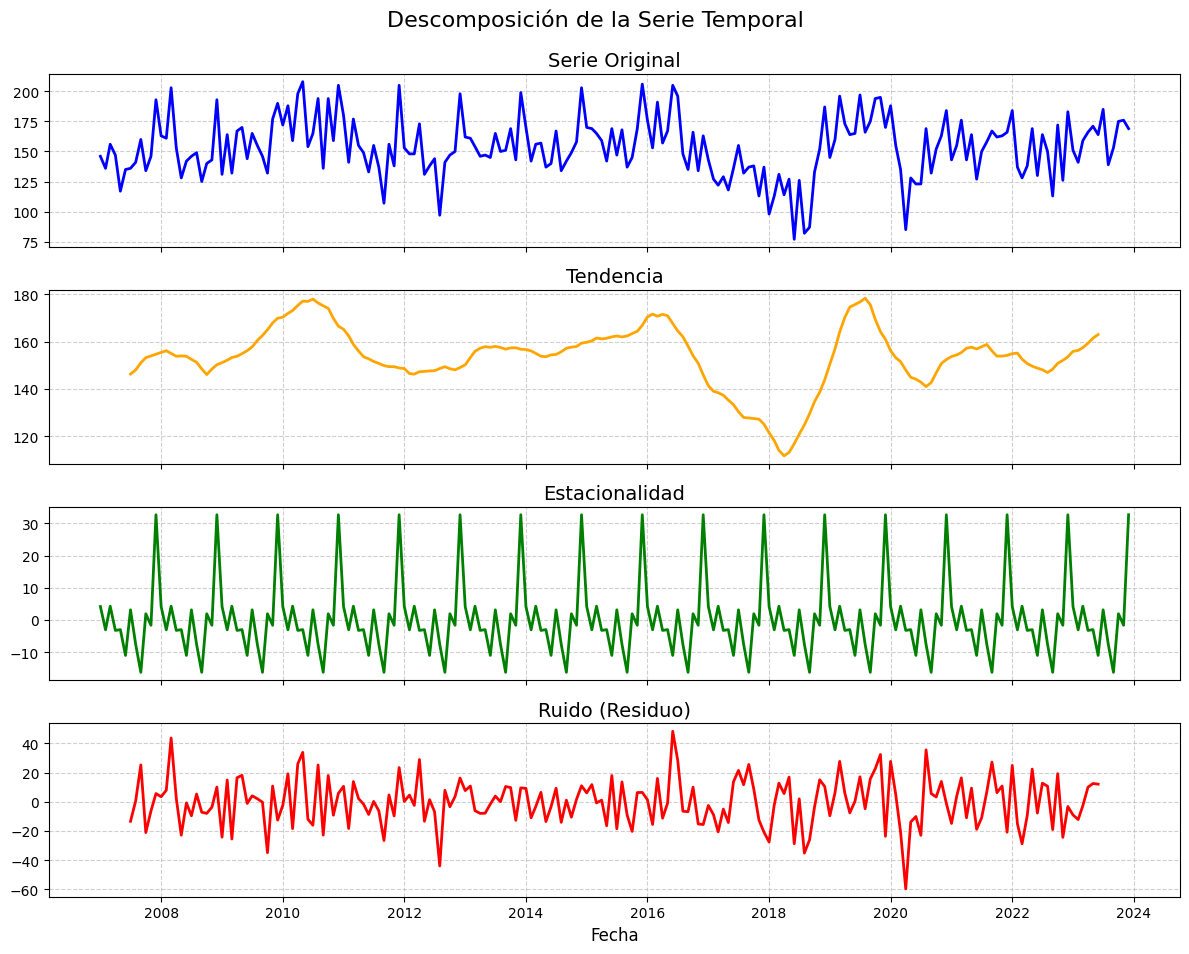

In [263]:
analisis_st.detectar_estacionalidad()

# Análisis de autocorrelación

<Figure size 1200x1000 with 0 Axes>

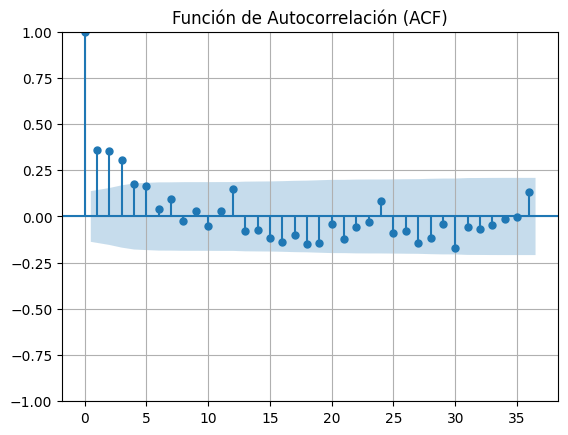

<Figure size 1200x1000 with 0 Axes>

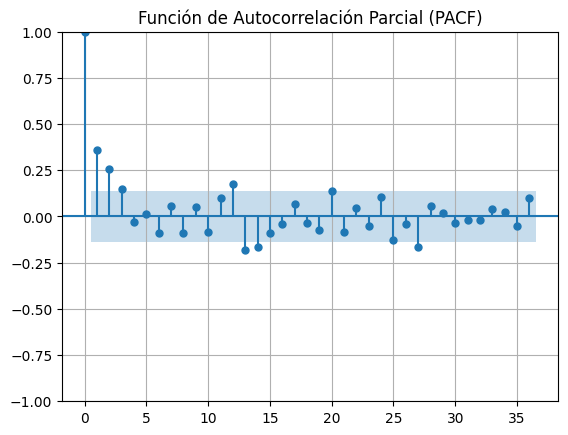

In [264]:
analisis_st.graficar_acf_pacf(lags=36)

## Interpretación de los lags

### ACF:

- Se presenta un pico cada 12 lags, lo que sugiere un patrón anual.
- Hay un decaimiento rápido entre el lag 1 y lag 2. Las barras caen dentro del intervalo de confianza con rapidez, lo que indica que no hay una dependencia a largo plazo en la serie
- Se puede ver un patrón de serie en los lags, estos presentan picos en temporadas anuales como lags 12, 24, 26. Este rebote es lo que demuestra la estacionalidad de la serie

### PACF:

- Hay una perdida rápida de significancia. 

## Análisis de las Gráficas ACF y PACF

### **Gráfica ACF (Función de Autocorrelación)**
1. **Lag 1**:
   - La correlación en el primer lag es muy alta (cercana a 0.75), lo que indica que la variable tiene una fuerte relación con su valor del periodo inmediatamente anterior.
   
2. **Lags significativos**:
   - Los lags 2 y 3 tienen correlaciones significativas que sobresalen del intervalo de confianza, lo que sugiere que también tienen impacto en la serie.
   - Después del tercer lag, las correlaciones disminuyen gradualmente y se acercan al intervalo de confianza.

3. **Tendencia a cero**:
   - La autocorrelación disminuye de manera lenta y persistente, lo que podría ser indicativo de no estacionaridad o una estructura autorregresiva en la serie.

4. **Estacionalidad**:
   - No se observan patrones regulares o repeticiones de picos en los lags, lo que sugiere que no hay una fuerte componente estacional en la serie.

---

### **Gráfica PACF (Función de Autocorrelación Parcial)**
1. **Lag 1**:
   - El primer lag muestra una correlación significativa (cercana a 0.75), indicando que el valor actual está altamente influenciado por el valor del periodo inmediatamente anterior.

2. **Lags significativos**:
   - Los lags 2 y 3 también son significativos, aunque con menor intensidad, lo que indica que las correlaciones directas entre estos lags y el valor actual son importantes.

3. **Lags posteriores**:
   - A partir del lag 4, las barras caen dentro del intervalo de confianza, lo que implica que los lags más lejanos no tienen una influencia directa significativa.

---

### **Conclusión Conjunta**
- **Modelo ARIMA/SARIMA**:
  - Con base en la ACF y la PACF, el modelo puede incluir:
    - **p=3** (3 términos autorregresivos) porque los primeros 3 lags de la PACF son significativos.
    - **q=2 o 3** (términos de media móvil), ya que los primeros 2-3 lags de la ACF son significativos.
    - La ausencia de patrones estacionales destacados sugiere que un componente estacional podría no ser necesario. Sin embargo, si se identificó estacionalidad previamente, podría incluirse.

- **Estacionaridad**:
  - La ACF muestra un descenso gradual en las correlaciones, lo que podría indicar no estacionaridad. Si no has aplicado diferenciación (`d`), sería recomendable probar con **d=1** para lograr estacionaridad.

- **Siguientes pasos**:
  - Probar un modelo **ARIMA(3,1,3)** o ajustar un modelo SARIMA si identificas estacionalidad en otros análisis.
  - Validar el modelo con métricas como AIC/BIC, MAE y MAPE para seleccionar el mejor ajuste.

Si necesitas apoyo implementando este modelo o ajustando los parámetros, ¡avísame! 😊


In [265]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -3.6734269015355294
p-value: 0.004502839670564938
Valores Críticos:
1%: -3.4652439354133255
5%: -2.8768752281673717
10%: -2.574944653739612
Rechazamos la hipótesis nula. La serie es estacionaria.


In [266]:
df_defunciones.set_index('fecha', inplace=True)

In [267]:
train_size = int(0.7 * len(df_defunciones))
y_train, y_test = df_defunciones[:train_size], df_defunciones[train_size:]

In [268]:
sarima = ss.SARIMAModel()

# Definir los rangos para los parámetros
p_range = range(4)
q_range = range(5)
seasonal_order_ranges = (
    range(2),  # P
    range(2),  # D
    range(2),  # Q
    [12]       # S
)

# Generar parámetros
parametros = sarima.generar_parametros(p_range, q_range, seasonal_order_ranges)
parametros[:5] # Ver algunas combinaciones

[(0, 0, (0, 0, 0, 12)),
 (0, 0, (0, 0, 1, 12)),
 (0, 0, (0, 1, 0, 12)),
 (0, 0, (0, 1, 1, 12)),
 (0, 0, (1, 0, 0, 12))]

100%|██████████| 160/160 [01:10<00:00,  2.25it/s]


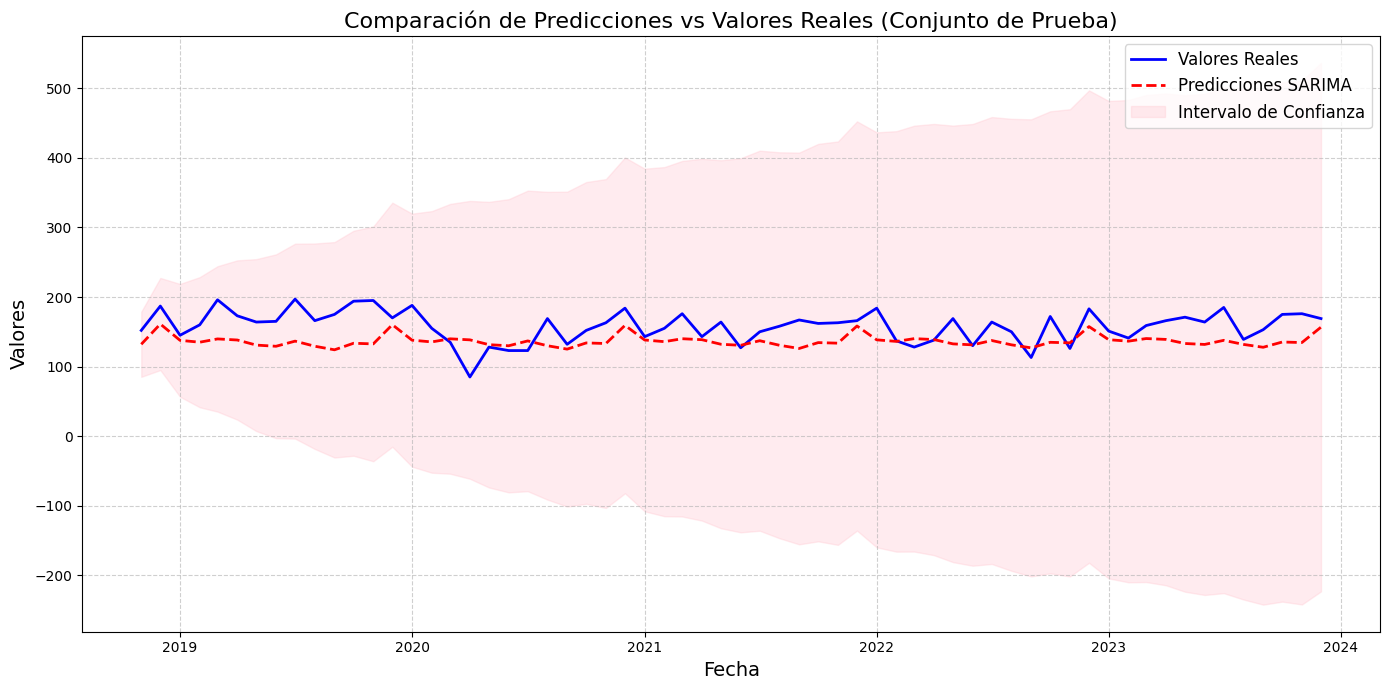

In [269]:
results_df = sarima.evaluar_modelos(y_train, y_test, parametros, diferenciacion=1, df_length=len(df_defunciones), variable="casos_defunciones")

In [270]:
# Ordenar resultados por RMSE
results_df = results_df.sort_values(by="RMSE", ascending=True)
results_df.head()

,p,q,seasonal_order,RMSE
5,0,0,"(1, 0, 1, 12)",30
0,0,0,"(0, 0, 0, 12)",33
7,0,0,"(1, 1, 1, 12)",34
3,0,0,"(0, 1, 1, 12)",34
1,0,0,"(0, 0, 1, 12)",34


In [271]:
modelo_sarima= SARIMAX(df_defunciones, 
                    order= (3,0,3),                    # d es 0 porque es estacionario
                    seasonal_order= (1,0,1,12)).fit()   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y= modelo_sarima.predict(start= len(df_defunciones), end=len(df_defunciones)+24)   #pongo el más 24 porque son los que quiero predecir

pred_y= pred_y.astype(int)
datos_predichos=pd.DataFrame(pred_y)

In [272]:
y_test.index = pd.to_datetime(y_test.index)
datos_predichos.index = pd.to_datetime(datos_predichos.index)

Text(0.5, 1.0, 'Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

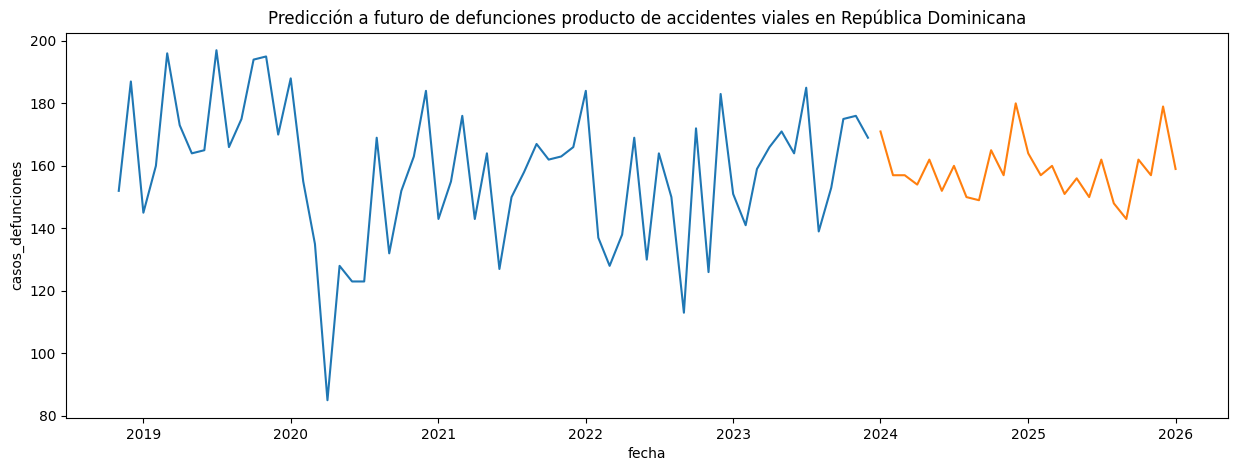

In [273]:
plt.figure(figsize=(15,5))

sns.lineplot(x=y_test.index, y='casos_defunciones', data=y_test)
sns.lineplot(x=datos_predichos.index, y='predicted_mean', data=datos_predichos)
plt.title('Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

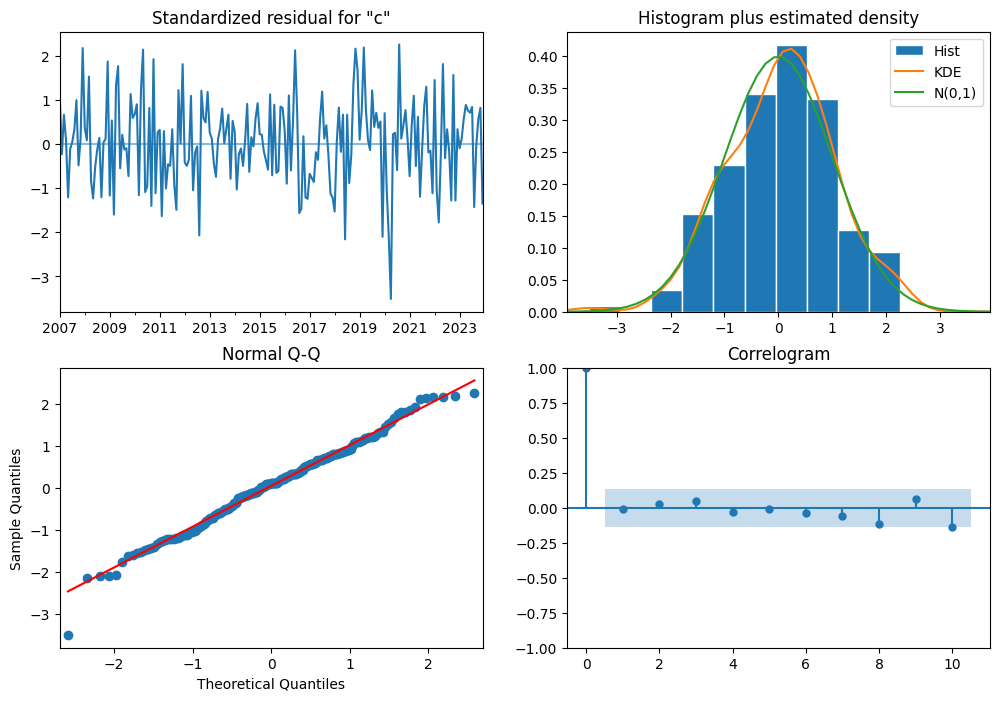

In [274]:
modelo_sarima.plot_diagnostics(figsize=(12, 8))
plt.show()

In [275]:
# Generar predicciones para el rango de y_test
pred_y = modelo_sarima.predict(start=y_test.index.min(), end=y_test.index.max())
pred_y = pred_y.astype(int)  # Convertir a enteros si es necesario

# Crear un DataFrame alineado con y_test
datos_predichos = pd.DataFrame(pred_y, columns=['predicted_mean'])
datos_predichos.index = y_test.index  # Alinear índices


In [276]:
# Predicción ajustada para el rango de y_test
pred_y_test = modelo_sarima.predict(start=y_test.index.min(), end=y_test.index.max())

# Crear DataFrame alineado
datos_predichos_y_test = pd.DataFrame(pred_y_test, columns=['predicted_mean'])
datos_predichos_y_test.index = y_test.index

mae = mean_absolute_error(y_test['casos_defunciones'], datos_predichos_y_test['predicted_mean'])
mape = mean_absolute_percentage_error(y_test['casos_defunciones'], datos_predichos_y_test['predicted_mean'])

print(f"MAE: {mae}, MAPE: {mape * 100:.2f}% ")


MAE: 17.64171370172527, MAPE: 11.80% 


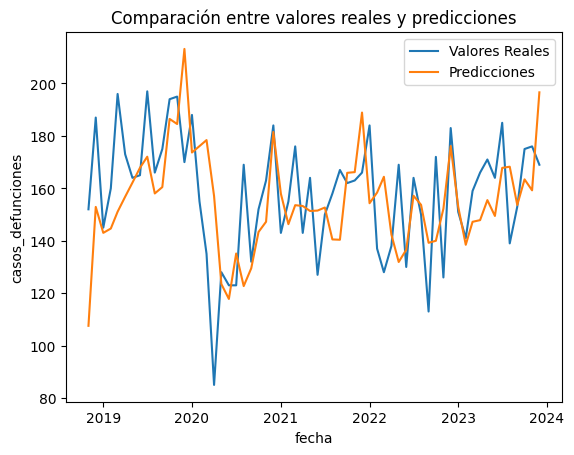

In [277]:
sns.lineplot(x=y_test.index, y=y_test['casos_defunciones'], label="Valores Reales")
sns.lineplot(x=y_test.index, y=datos_predichos_y_test['predicted_mean'], label="Predicciones")
plt.title("Comparación entre valores reales y predicciones")
plt.show()


In [282]:
# Predicción en toda la serie histórica
pred_toda_serie = modelo_sarima.predict(start=df_defunciones.index.min(), end=df_defunciones.index.max())

# Crear DataFrame para las predicciones
datos_predichos_toda_serie = pd.DataFrame(pred_toda_serie, columns=['predicted_mean'])
datos_predichos_toda_serie.index = df_defunciones.index

# Calcular métricas de error en toda la serie
mae_toda_serie = mean_absolute_error(df_defunciones['casos_defunciones'], datos_predichos_toda_serie['predicted_mean'])
mape_toda_serie = mean_absolute_percentage_error(df_defunciones['casos_defunciones'], datos_predichos_toda_serie['predicted_mean'])
rmse = np.sqrt(mean_squared_error(y_test['casos_defunciones'], datos_predichos_y_test['predicted_mean']))

print(f"MAE para toda la serie: {mae_toda_serie}")
print(f"MAPE para toda la serie: {mape_toda_serie * 100:.2f}%")
print(f'RMSE para toda la serie: {rmse}')


MAE para toda la serie: 16.83164529943302
MAPE para toda la serie: 11.38%
RMSE para toda la serie: 22.756321606086015


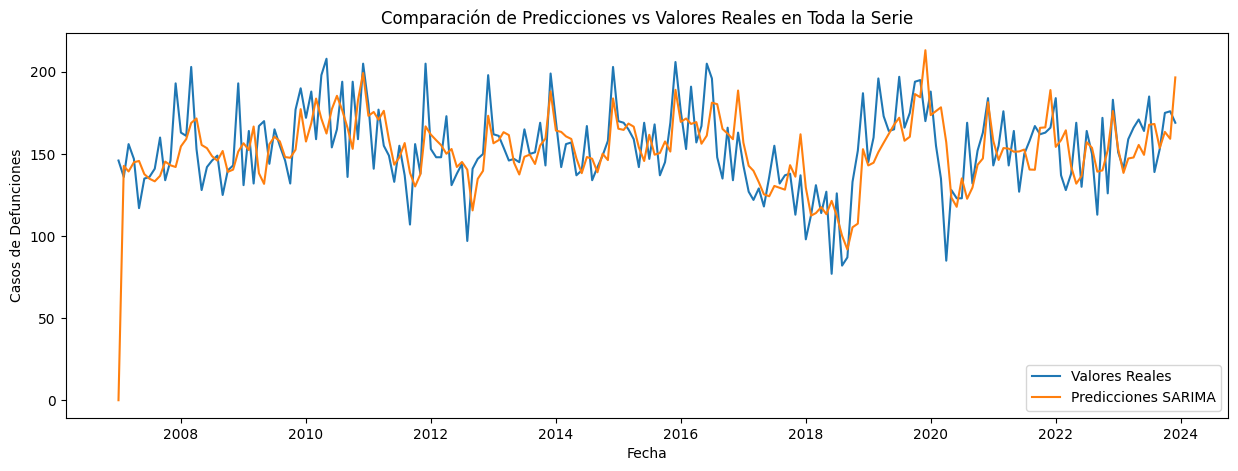

In [280]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=df_defunciones.index, y=df_defunciones['casos_defunciones'], label='Valores Reales')
sns.lineplot(x=datos_predichos_toda_serie.index, y=datos_predichos_toda_serie['predicted_mean'], label='Predicciones SARIMA')
plt.title("Comparación de Predicciones vs Valores Reales en Toda la Serie")
plt.xlabel("Fecha")
plt.ylabel("Casos de Defunciones")
plt.legend()
plt.show()


In [278]:
# # Encuentra el índice común
# indice_comun = y_test.index.intersection(datos_predichos.index)

# # Filtra ambas series para que tengan el mismo rango de fechas
# y_test_alineado = y_test.loc[indice_comun, 'casos_defunciones']
# datos_predichos_alineado = datos_predichos.loc[indice_comun, 'predicted_mean']


In [254]:
df_defunciones.reset_index(inplace=True)

## Modelo usando Prophet

In [219]:
df_defunciones.columns = ['ds', 'y']

In [229]:
df_defunciones.tail()

,ds,y
199,2023-08-01,139
200,2023-09-01,153
201,2023-10-01,175
202,2023-11-01,176
203,2023-12-01,169


In [221]:
m = Prophet()
m.fit(df_defunciones)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=25, freq='MS') 
m.predict(df_defunciones)

00:37:08 - cmdstanpy - INFO - Chain [1] start processing
00:37:09 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-01-01,156,131,190,156,156,4,4,4,4,4,4,0,0,0,159
1,2007-02-01,156,122,179,156,156,-4,-4,-4,-4,-4,-4,0,0,0,152
2,2007-03-01,155,130,187,155,155,4,4,4,4,4,4,0,0,0,160
3,2007-04-01,155,125,180,155,155,-2,-2,-2,-2,-2,-2,0,0,0,153
4,2007-05-01,155,124,179,155,155,-4,-4,-4,-4,-4,-4,0,0,0,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2023-08-01,152,113,170,152,152,-9,-9,-9,-9,-9,-9,0,0,0,143
200,2023-09-01,152,108,162,152,152,-16,-16,-16,-16,-16,-16,0,0,0,135
201,2023-10-01,151,126,181,151,151,3,3,3,3,3,3,0,0,0,155
202,2023-11-01,151,124,178,151,151,0,0,0,0,0,0,0,0,0,152


In [222]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
224,2025-09-01,136,107,163
225,2025-10-01,154,126,180
226,2025-11-01,151,124,179
227,2025-12-01,183,154,212
228,2026-01-01,155,127,183


In [223]:
df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[:204]
df['defunciones'] = df_defunciones['y']
df.tail(5)

,ds,yhat,yhat_lower,yhat_upper,defunciones
199,2023-08-01,143,114,170,139
200,2023-09-01,135,109,164,153
201,2023-10-01,155,126,182,175
202,2023-11-01,152,122,179,176
203,2023-12-01,183,153,211,169


In [224]:
# Seleccionar las columnas relevantes
y_real = df['defunciones']
y_pred = df['yhat']

# Cálculo de MAE
mae = mean_absolute_error(y_real, y_pred)

# Cálculo de MAPE
mape = mean_absolute_percentage_error(y_real, y_pred)

# Cálculo de RMSE
rmse = np.sqrt(mean_squared_error(y_real, y_pred))

# Imprimir los resultados
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")


MAE: 16.811434077383815
MAPE: 11.77%
RMSE: 21.806114837171673


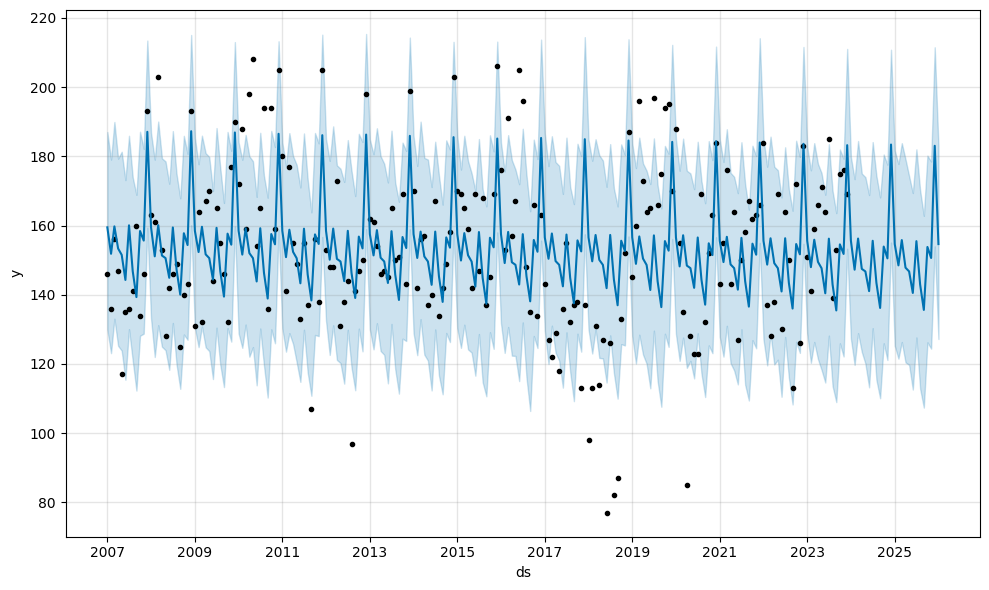

In [225]:
fig1 = m.plot(forecast)

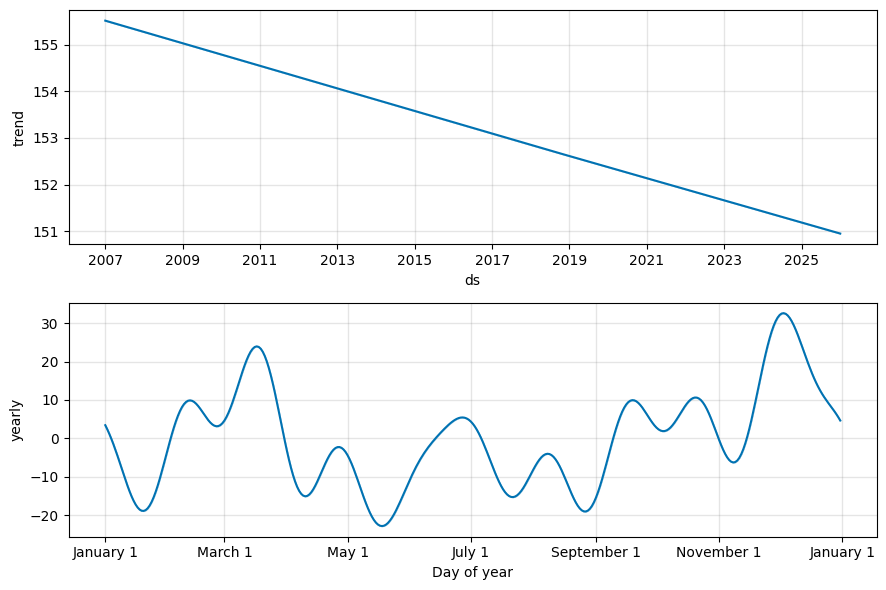

In [226]:
fig2 = m.plot_components(forecast)

In [227]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [228]:
plot_components_plotly(m, forecast)